In [37]:
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.special import logsumexp
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from numba import njit #,jit,int32,float32,int64,float64,typeof

In [2]:
def simulate_selected_forwards(p0,s_locus,tOn,tOff,N=10000):
    #Generate an allele frequency trajectory forward in time under selection.
    #p0 is the frequency of the allele when selection starts.
    #N is the (constant, diploid) population size.
    #delta is the interval between time steps.
    delta = 1/(2*N)
    traj = [p0]
    time = tOn
    currTime = tOn
    while time > 0:

        #change s depending on pulse timing
        if time > tOff:
            s_t = s_locus
        else:
            s_t = 0
        currFreq = traj[-1]
        if(currFreq > 0 and currFreq < 1):
            nextFreq = np.random.normal(currFreq + delta*2*N*s_t*currFreq*(1-currFreq), np.sqrt(delta) * np.sqrt(currFreq*(1-currFreq)) )
            if nextFreq > 1:
                nextFreq = 1
            if nextFreq < 0:
                nextFreq = 0
            traj.append(nextFreq)
        else:
            traj.append(currFreq)


        time -= delta * (2*N)
        #if time < 1e-8:
        #   print(time,traj[-1])
    return traj

def simulate_neutral_backwards(p0,s_locus,N=10000,stop=None):
    delta = 1/(2*N)
    traj = [p0]
    i = 0
    while traj[-1] != 1 and traj[-1] != 0:
        curr = traj[-1]
        nextFreq = np.random.normal(curr*(1 - delta), np.sqrt(delta) * np.sqrt(curr*(1-curr)) )
        if nextFreq > 1:
            nextFreq = 1
        if nextFreq < 0:
            nextFreq = 0
        traj.append(nextFreq)
        if stop != None and i == stop:
            if traj[:-1] == 0:
                return traj[1:-1]
            else:
                return traj[1:]
        i += 1
    return traj[1:]

In [54]:


@njit('float64(float64[:])',cache=True)
def _logsumexp(a):
    a_max = np.max(a)

    tmp = np.exp(a - a_max)

    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out

@njit('float64(float64[:],float64[:])',cache=True)
def _logsumexpb(a,b):

    a_max = np.max(a)

    tmp = b * np.exp(a - a_max)

    s = np.sum(tmp)
    out = np.log(s)

    out += a_max
    return out

@njit('float64(float64)',cache=True)
def _log_phi(z):
	logphi = -0.5 * np.log(2.0* np.pi) - 0.5 * z * z
	return logphi


@njit('float64[:,:](float64[:,:],float64[:,:])',cache=True)
def _log_prob_mat_mul(A,B):
    # multiplication of probability matrices in log space
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            C[i,j] = _logsumexp( A[i,:] + B[:,j])
            if np.isnan(C[i,j]):
                C[i,j] = np.NINF
        ## special sauce...
        C[i,:] -= _logsumexp(C[i,:])
    return C

@njit('float64[:,:](float64[:,:],int64)',cache=True)
def _log_matrix_power(X,n):
    ## find log of exp(X)^n (pointwise exp()!) 

    # use 18 because you are fucked if you want trans
    # for dt > 2^18...
    #print('Calculating matrix powers...')

    maxlog2dt = 18
    assert(np.log(n)/np.log(2) < maxlog2dt)
    assert(X.shape[0] == X.shape[1])
    b = 1
    k = 0
    matrices = np.zeros((X.shape[0],X.shape[1],maxlog2dt))
    matrices[:,:,0] = X
    
    while b < n:
        #print(b,k)
        k += 1
        b += 2**k
        # square the last matrix
        matrices[:,:,k] = _log_prob_mat_mul(matrices[:,:,k-1],
                                           matrices[:,:,k-1])
    leftover = n
    Y = np.NINF * np.ones((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        Y[i,i] = 0
        
    while leftover > 0:
        #print(n-leftover,k)
        if 2**k <= leftover:
            Y = _log_prob_mat_mul(Y,matrices[:,:,k])
            leftover -= 2**k
        k -= 1
        
    return Y

@njit('float64[:](int64,float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def _log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	# 1-generation transition prob based on Normal distn
	
	p = FREQS[i]
	lf = len(FREQS)
	logP = np.NINF * np.ones(lf)

	if p <= 0.0:
		logP[0] = 0
	elif p >= 1.0:
		logP[lf-1] = 0
		return logP
	else:
		#plo = (FREQS[i]+FREQS[i-1])/2
		#phi = (FREQS[i]+FREQS[i+1])/2
		if s != 0:
			mu = p - s*p*(1.0-p)*dt
            #p - s*p*(1.0-p)/np.tanh(2*N*s*(1-p))*dt
			# mulo = plo - s*plo*(1.0-plo)/np.tanh(2*N*s*(1-plo))*dt
			# muhi = phi - s*phi*(1.0-phi)/np.tanh(2*N*s*(1-phi))*dt
		else:
			mu = p #- p * 1/(4.0*N)*dt
			# mulo = plo - plo * 1/(2.0*N)*dt
			# muhi = phi - phi * 1/(2.0*N)*dt
		sigma = np.sqrt(p*(1.0-p)/(4.0*N)*dt)
		# sigmalo = np.sqrt(plo*(1.0-plo)/(2.0*N)*dt)
		# sigmahi = np.sqrt(phi*(1.0-phi)/(2.0*N)*dt)
                      
		pi0 = np.interp(np.array([(FREQS[0]-mu)/sigma]),z_bins,z_logcdf)[0]
		pi1 = np.interp(np.array([(FREQS[lf-1]-mu)/sigma]),z_bins,z_logsf)[0]

		x = np.array([0.0,pi0,pi1])
		b = np.array([1.0,-1.0,-1.0])
		middleNorm = _logsumexpb(x,b)
        
		# x = np.array([0.0,pi0lo,pi1lo,0.0,pi0hi,pi1hi])
		# b = np.array([0.5,-0.5,-0.5,0.5,-0.5,-0.5])
		# middleNorm = _logsumexpb(x,b)

		middleP = np.zeros(lf-2)
		for j in range(1,lf-1):
			if j == 1:
				mlo = FREQS[0]
			else:
				mlo = np.mean(np.array([FREQS[j],FREQS[j-1]]))
			if j == lf-2:
				mhi = FREQS[j+1]
			else:
				mhi = np.mean(np.array([FREQS[j],FREQS[j+1]]))
    
			l1 = np.interp(np.array([(mlo-mu)/sigma]),z_bins,z_logcdf)[0]
			l2 = np.interp(np.array([(mhi-mu)/sigma]),z_bins,z_logcdf)[0]
			middleP[j-1] = _logsumexpb(np.array([l1,l2]),np.array([-1.0,1.0]))                    


		logP[0] = pi0
		logP[1:lf-1] = middleP
		logP[lf-1] = pi1

	return logP

@njit('float64[:,:](float64,float64,float64[:],float64[:],float64[:],float64[:],int64)',cache=True)
def _nstep_log_trans_prob(N,s,FREQS,z_bins,z_logcdf,z_logsf,dt):
	lf = len(FREQS)
	p1 = np.zeros((lf,lf))

	# load rows into p1
	for i in range(lf):
		row = _log_trans_prob(i,N,s,FREQS,z_bins,z_logcdf,z_logsf,1)
		p1[i,:] = row

	# exponentiate matrix
	# exponentiate matrix
	pn = _log_matrix_power(p1,int(dt))
	return pn

@njit('float64(float64[:],float64)')
def _genotype_likelihood_emission(ancGLs,p):
	logGenoFreqs = np.array([2*np.log(1-p),np.log(2) + np.log(p) + np.log(1-p),2*np.log(p)])
	emission = _logsumexp(logGenoFreqs + ancGLs)
	if np.isnan(emission):
		emission = -np.inf
	return emission

@njit('float64[:,:](float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],float64[:,:])',cache=True)
def forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancientGLs):

    '''
    Moves forward in time from past to present
    '''
    
    # neutral SFS prior on initial frequency
    lf = len(freqs)
    #bws = np.diff(np.concatenate((freqs,[1.0])))
    #alpha = -np.log(freqs) + np.log(bws)
    
    alpha = np.zeros(lf)
    alpha -= _logsumexp(alpha)
    
    T = len(epochs)-1
    alphaMat = np.zeros((T+1,lf))
    alphaMat[-1,:] = alpha
    
    
    prevNt = -1
    prevst = -1
    prevdt = -1
    
    cumGens = epochs[-1]
    for tb in range(T-1,0,-1):
        dt = -epochs[tb]+epochs[tb+1]
        Nt = N[tb]
        st = sel[tb]
        prevAlpha = np.copy(alpha)
        
        if prevNt != Nt or prevst != st or prevdt != dt:
            #print(Nt,st,dt)
            currTrans = _nstep_log_trans_prob(Nt,st,freqs,z_bins,z_logcdf,z_logsf,dt)
        
        #grab ancient GL rows
        ancientGLrows = ancientGLs[ancientGLs[:,0] <= cumGens]
        ancientGLrows = ancientGLrows[ancientGLrows[:,0] > cumGens - dt]

        glEmissions = np.zeros(lf)
        for j in range(lf):
            for iac in range(ancientGLrows.shape[0]):
                glEmissions[j] += _genotype_likelihood_emission(ancientGLrows[iac,1:],freqs[j])
        
        #print(tb,ancientGLrows)
        for i in range(lf):
            alpha[i] = _logsumexp(prevAlpha + currTrans[i,:]+ glEmissions) 
            if np.isnan(alpha[i]):
                alpha[i] = -np.inf
        
        prevNt = Nt
        prevdt = dt
        prevst = st
        cumGens -= dt
        alphaMat[tb,:] = alpha
    return alphaMat
    
@njit('float64[:,:](float64[:],float64[:],float64[:],float64[:],float64,float64[:],float64[:],float64[:],float64[:,:])',cache=True)
def backward_algorithm(sel,epochs,N,freqs,currFreq,z_bins,z_logcdf,z_logsf,ancientGLs):

    '''
    Moves backward in time from present to past
    '''
    nsamp = 1000
    # neutral SFS prior on initial frequency
    lf = len(freqs)
    alpha = np.zeros(lf)
    #s2 = 1 * currFreq * (1-currFreq) 
    for i in range(lf):
        k = int(currFreq*nsamp)
        #alpha[i] = stats.binom.logpmf(np.int64(currFreq*nsamp),nsamp,freqs[i])
        alpha[i] = -np.sum(np.log(np.arange(2,k+1)))
        alpha[i] += np.sum(np.log(np.arange(2,nsamp-k+1)))
        alpha[i] += k*np.log(freqs[i]) + (nsamp-k)*np.log(1-freqs[i])
    #print(alpha)
    T = len(epochs)-1
    alphaMat = np.zeros((T+1,lf))
    alphaMat[0,:] = alpha
    
    
    prevNt = -1
    prevst = -1
    prevdt = -1
    
    cumGens = epochs[-1]
    for tb in range(0,T):
        dt = epochs[tb+1]-epochs[tb]
        Nt = N[tb]
        st = sel[tb]
        prevAlpha = np.copy(alpha)
        
        if prevNt != Nt or prevst != st or prevdt != dt:
            #print(Nt,st,dt)
            currTrans = _nstep_log_trans_prob(Nt,st,freqs,z_bins,z_logcdf,z_logsf,dt)
        
        #grab ancient GL rows
        ancientGLrows = ancientGLs[ancientGLs[:,0] > cumGens]
        ancientGLrows = ancientGLrows[ancientGLrows[:,0] <= cumGens + dt]

        glEmissions = np.zeros(lf)
        for j in range(lf):
            for iac in range(ancientGLrows.shape[0]):
                glEmissions[j] += _genotype_likelihood_emission(ancientGLrows[iac,1:],freqs[j])
        
        #print(tb,ancientGLrows)
        for i in range(lf):
            alpha[i] = _logsumexp(prevAlpha + currTrans[:,i] ) + glEmissions[i]
            if np.isnan(alpha[i]):
                alpha[i] = -np.inf
        
        prevNt = Nt
        prevdt = dt
        prevst = st
        cumGens += dt
        alphaMat[tb,:] = alpha
    return alphaMat


In [130]:
def simulate_traj_and_gls(p0,s,tOn,tOff,Ne=1*10**4,gens=500,tSkip=1):
    # simulating trajectory with a pulse of selection
    # also sample genotype likelihoods

    traj = simulate_selected_forwards(p0,s,tOn,tOff,N=Ne)
    traj = traj[::-1]
    traj += simulate_neutral_backwards(p0,0,Ne)

    n = 1*10**3
    nCurr = np.random.binomial(n,traj[0])

    # simulating sampling ancient GLs
    ancGLs = np.zeros((gens//tSkip,4))
    ancGLs[:,0] = np.arange(0,gens,tSkip)
    ancGLs[:,1:] = -np.inf
    genos = []
    for t in range(0,gens//tSkip):
        geno = np.random.binomial(2,traj[t*tSkip])
        genos.append(geno)
        ancGLs[t,geno+1] = 0.0
    
    return traj, ancGLs, genos

def initialize_pulse_model(traj,s,tOn,tOff,Ne=1*10**4,gens=500):  
    # setting up HMM model
    epochs = np.arange(0,gens+1,dtype=float)
    sel = np.zeros(gens)
    sel[(epochs[:-1] < tOn) & (epochs[:-1] >= tOff)] = s

    N = Ne * np.ones(gens)

    a=0.75
    b=a
    c = 1/(2*Ne)
    df = 150
    freqs = stats.beta.ppf(np.linspace(c,1-c,df),a,b)
    currentFreq = traj[0]
    
    return sel,epochs,N,freqs,currentFreq,ancGLs

def initialize_epoch_model(traj,S,timeBins,Ne=1*10**4,gens=500):  
    # setting up HMM model
    epochs = np.arange(0,gens,dtype=float)
    sel = S[np.digitize(epochs,timeBins)-1]

    N = Ne * np.ones(gens)

    a=0.75
    b=a
    c = 1/(2*Ne)
    df = 150
    freqs = stats.beta.ppf(np.linspace(c,1-c,df),a,b)
    currentFreq = traj[0]
    
    return sel,epochs,N,freqs,currentFreq,ancGLs

def load_normal_tables():
    # read in global Phi(z) lookups
    z_bins = np.genfromtxt('z_bins.txt')
    z_logcdf = np.genfromtxt('z_logcdf.txt')
    z_logsf = np.genfromtxt('z_logsf.txt')
    return z_bins,z_logcdf,z_logsf

def plot_trajs(trueTraj,alphaMat,betaMat,freqs,genos,gens=500,tSkip=1):
    postFreq = (alphaMat + betaMat).transpose()
    postFreq -= logsumexp(postFreq,axis=0)
    plt.pcolormesh(range(gens+1),freqs,np.exp(postFreq[:,:]),cmap='plasma_r')
    plt.colorbar()
    plt.plot(trueTraj,label='true')

    plt.scatter(range(0,gens,tSkip),1/2*np.array(genos),alpha=0.2,c='k',label='ancient genotypes')
    plt.axis((0,500,-0.05,1.05))
    plt.ylabel('freq')
    plt.xlabel('time before present')
    plt.legend()    
    return



# Quick demo

The cell below demonstrates (1) simulation of the trajectory (and genotypes) and (2) inference of the trajectory, conditional on some model of selection (here, a 'pulse' model where s != 0 for some time period defined by tOn, tOff.

In [ ]:

### 1 ### Simulation

sTrue = 0.01
tOnTrue = 300
tOffTrue = 100
p0 = 0.05
Ne = 1*10**4
gens = 500
tSkip = 1

traj, ancGLs, genos = simulate_traj_and_gls(p0,sTrue,tOnTrue,tOffTrue,Ne=Ne,gens=gens,tSkip=tSkip)

##########
### 2 ### Inference (fixing the values of s/tOn/tOff)

sNominal = 0.01
tOnNominal = 300
tOffNominal = 100

sel,epochs,N,freqs,currentFreq,ancGLs = initialize_pulse_model(traj,sNominal,tOnNominal,tOffNominal,Ne=Ne,gens=gens)
z_bins,z_logcdf,z_logsf = load_normal_tables()

alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
betaMat = backward_algorithm(sel,epochs,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs)

plot_trajs(traj,alphaMat,betaMat,freqs,genos,gens=500,tSkip=tSkip)
    
##########


# Optimization over S

In fact we never know the selection S, so here I'm showing how to estimate S (a vector, signifying a selection coefficient changing over time). I use Nelder Mead to optimize. No particular reason why I choose that method, but it seems to work fairly well -- it can optimize over 5 time periods in a couple minutes. 

In [128]:
def likelihood_wrapper(theta,timeBins,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs,gens):
    S = theta
    
    if np.any(np.abs(S) > 0.1):
        return np.inf

    epochs = np.arange(0,gens+1,dtype=float)
    sel = S[np.digitize(epochs,timeBins,right=False)-1]
    alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
    betaMat = backward_algorithm(sel,epochs,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs)
    logl = -logsumexp(alphaMat[1,:]+betaMat[1,:])
    print(logl,S)
    return logl


S0 = 1e-3 * np.ones(6)
timeBins = np.linspace(0,500,6)

Simplex = np.zeros((7,6))
for i in range(Simplex.shape[0]-1):
    Simplex[i,:] = -0.01
    Simplex[i,i] = 0.01
Simplex[-1,:] = 0.01
    
#for tup in product(*[[-1,1] for i in range(3)]):
    

args = (timeBins,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs,gens)
minimize(likelihood_wrapper,
         S0,
         args=args,
         options={'xatol':1e-5,'initial_simplex':Simplex},
        method='Nelder-Mead')

-2656.318864829 [ 0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
-2660.2628948783613 [-0.01  0.01 -0.01 -0.01 -0.01 -0.01]
-2648.5196252513324 [-0.01 -0.01  0.01 -0.01 -0.01 -0.01]
-2632.6696659165154 [-0.01 -0.01 -0.01  0.01 -0.01 -0.01]
-2623.648957605895 [-0.01 -0.01 -0.01 -0.01  0.01 -0.01]
-2619.443172091064 [-0.01 -0.01 -0.01 -0.01 -0.01  0.01]
-2682.0674470896665 [0.01 0.01 0.01 0.01 0.01 0.01]
-2677.695686992917 [ 0.00333333  0.00333333  0.00333333  0.00333333  0.00333333 -0.02333333]
-2680.810748642891 [ 0.00777778  0.00777778  0.00777778  0.00777778 -0.01888889 -0.00777778]
-2677.1382745370115 [ 0.0137037   0.0137037   0.0137037  -0.01296296 -0.00185185 -0.00703704]
-2663.692859703413 [ 0.02160494  0.02160494 -0.00506173  0.00604938  0.0008642  -0.00604938]
-2668.16714922144 [ 0.00547325  0.03213992  0.01658436  0.01139918  0.0044856  -0.00473251]
-2646.2509303012234 [ 0.030631    0.01951989  0.02544582  0.01853224  0.00931413 -0.00297668]
-2678.297651571609 [ 0.00015775  0.01237997 -0.

KeyboardInterrupt: 

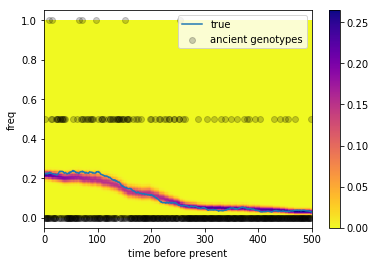

In [129]:
S = np.array([0.00292551, 0.00917736, 0.01740725, 0.00621393, 0.01770234, 0.00220417])
timeBins = np.linspace(0,500,6)
epochs = np.arange(0,gens+1,dtype=float)
sel = S[np.digitize(epochs,timeBins)-1]

alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
betaMat = backward_algorithm(sel,epochs,N,freqs,currentFreq,z_bins,z_logcdf,z_logsf,ancGLs)

plot_trajs(traj,alphaMat,betaMat,freqs,genos,gens=500,tSkip=tSkip)
    

Text(0.5, 0, 'Selection coeff')

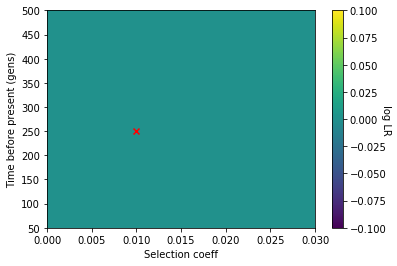

In [43]:
## grid search

Ss = np.linspace(0,0.03,10)
Ts = [50,100,150,200,250,300,350,400,450,500]

Ls = np.zeros((len(Ss),len(Ts)))

'''
for i,S in enumerate(Ss):
    for j,tOn in enumerate(Ts):
        sel = np.zeros(gens)
        sel[epochs[:-1] < tOn] = S
        alphaMat = forward_algorithm(sel,epochs,N,freqs,z_bins,z_logcdf,z_logsf,ancGLs)
        L = _logsumexp(alphaMat[1,:] + stats.binom.logpmf(nCurr,n,freqs))
        Ls[i,j] = L
        print(S,tOn,L)
'''

plt.pcolormesh(Ss,Ts,Ls-Ls[0,0],shading='gouraud')
cbar = plt.colorbar()
cbar.set_label('log LR', rotation=270)
#plt.xticks([0.0,0.01,0.02,0.03,0.04,0.05])
plt.scatter(0.01,250,marker='x',color='r')
plt.ylabel('Time before present (gens)')
plt.xlabel('Selection coeff')